In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

generariamo delle immagini a sfondo nero in *opencv*

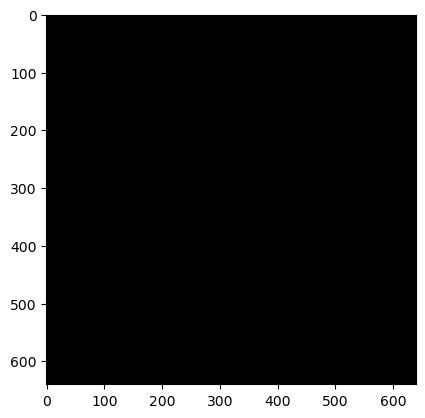

In [2]:
H,W,C = 640,640,3
dims = (H,W,C) # cv2 interpreta l'ultima dimensione come numero di canali dell'immagine
img = np.zeros(dims,np.uint8) # dovrebbe impostare il colore nero
plt.imshow(img)

ora generiamo una linea con le [funzioni di opencv](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html)

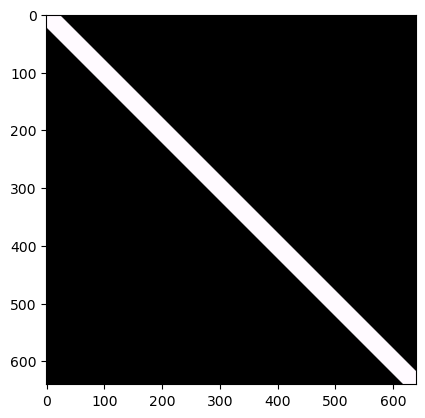

In [3]:
# cv2.line modifica l'immagine che gli viene data in input, perciò creiamo una nuova immagine
img2 = np.zeros(dims,np.uint8)
white_color = (255,250,255)
start_point = (0,0)
end_point = (640,640)
thickness = 30
cv2.line(img2,start_point,end_point,white_color,thickness)
plt.imshow(img2)

 aggiungiamo un parametro per controllare **l'inclinazione** della linea

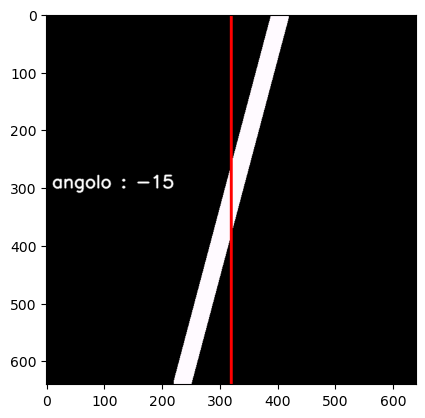

In [4]:
img3 = np.zeros(dims,np.uint8)

center_cols = W // 2

angle = -15 # in gradi
rad = angle * np.pi / 180 # convertiamo in radianti
alfa = np.tan(rad) # otteniamo il coeff. angolare della linea
y2 = int(alfa * (H // 2)) # e l'offset da sommare o sottrarre a center_cols

cv2.line(img3,(center_cols - y2,0),(center_cols + y2,640),(255, 250, 255),30)
red_color = (255,0,0)
cv2.line(img3,(center_cols,0),(center_cols,640),red_color,3)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img3,f'angolo : {angle}',(10,300), font, 1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img3)

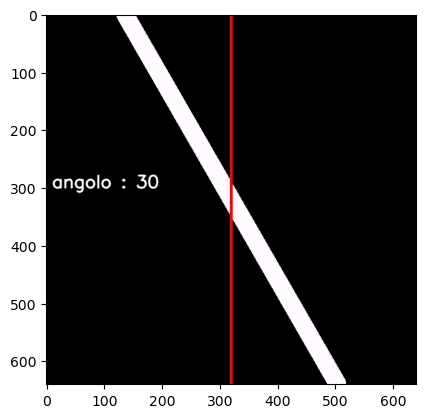

In [5]:
img4 = np.zeros(dims,np.uint8)

center_cols = W // 2

angle = +30 # in gradi
rad = angle * np.pi / 180 # convertiamo in radianti
alfa = np.tan(rad) # otteniamo il coeff. angolare della linea
y2 = int(alfa * (H // 2)) # e l'offset da sommare o sottrarre a center_cols

cv2.line(img4,(center_cols - y2,0),(center_cols + y2,640),(255, 250, 255),30)
red_color = (255,0,0)
cv2.line(img4,(center_cols,0),(center_cols,640),red_color,3)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img4,f'angolo : {angle}',(10,300), font, 1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img4)

ora possiamo generare delle immagini di linee bianche su sfondo nero, con un' inclinazione compresa tra **-45** e **45** *gradi*

aggiungiamo un parametro ***offset***: positivo(+) per spostare la linea a destra, negativo per spostarla a sinistra.

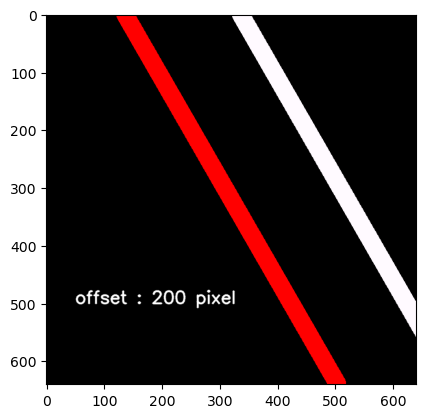

In [6]:
offset = +200 
img5 = np.zeros(dims,np.uint8)

cv2.line(img5,(center_cols - y2 + offset,0),(center_cols + y2 + offset,640),(255, 250, 255),30)
red = (255,0,0)
cv2.line(img5,(center_cols - y2,0),(center_cols + y2,640),red,30)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img5,f'offset : {offset} pixel',(50,500), font, 1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img5)

ora mettiamo tutto insieme e scriviamo una funzione che prende in input
1. l'angolo
2. l'offset
3. H e W dell'immagine
4. background e line color

e ritorna *l'immagine* 

In [7]:
def gen_image(H,W,angle,offset,background_color,line_color,line_width=30):
    dims = (H,W,3)
    img = np.full(dims, background_color, dtype=np.uint8)

    rad = angle * np.pi / 180 # convertiamo in radianti
    alfa = np.tan(rad) # otteniamo il coeff. angolare della linea
    y2 = int(alfa * (H // 2)) # e l'offset da sommare o sottrarre a center_cols

    center_rows = H // 2
    center_cols = W // 2
    
    cv2.line(img,(center_cols - y2 + offset,0),(center_cols + y2 + offset,H),line_color,line_width,lineType=cv2.LINE_AA)
    return img

In [8]:
black = (0,0,0)
white = (255,250,255)
blue = (173,216,230)
orange = (255,165,0)

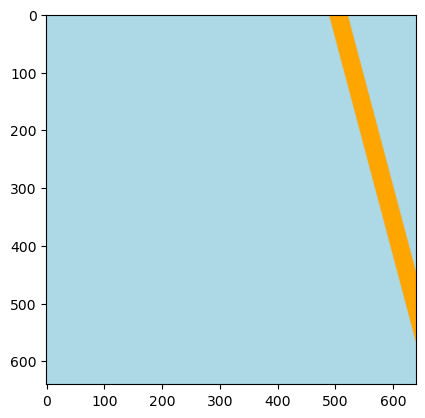

In [9]:
plt.imshow(gen_image(640,640,15,270,blue,orange))

e scriviamo una funzione che prende in input un'immagine e 

1. applica un **filtro gaussiano**
2. aggiunge del **rumore gaussiano**

In [10]:
def apply_effects(img):
    # applichiamo il filtro gaussiano
    img = img.astype(np.float32)
    img = cv2.GaussianBlur(img,(5,5),0)
    # aggiungiamo rumore gaussiano
    img = img + np.random.normal(0, 13, img.shape)
    img = img.clip(0,255).astype(np.uint8)
    return img

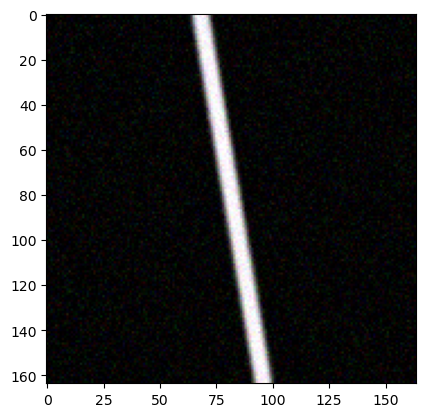

In [11]:
plt.imshow(apply_effects(gen_image(164,164,10,0,black,white,5)))

Per fare il training, abbiamo bisogno di un ds. Il ds viene generato in questo modo: 

le immagini hanno dimensione 224x224x3. Vengono salvare in formato png. Ad ogni immagine è associata un label compreso tra -1 e 1 (ottenuto dividendo l'angolo associato all'immagine per 45).

Il file con i label è in formato json.


In [12]:
import json
from pathlib import Path
import cv2

def gen_ds(imgs_path = Path('ds/images'),labels_path = Path('ds/labels')):
    label_dict = dict()
    imgs_path.mkdir(parents=True, exist_ok=True)
    labels_path.mkdir(parents=True, exist_ok=True)
    i = 0 
    for angle in range(-45, 45):
        for offset in range(-100,100,20):
            img = apply_effects(gen_image(224, 224, angle, offset, black, white, 9))    
            # Salva l'immagine
            cv2.imwrite(str(imgs_path / f'img_{i}.png'), img)            
            # Salva l'angolo
            label_dict[str(i)] = angle / 45
            i += 1
    with open(labels_path / 'labels.json', 'w') as f:
        json.dump(label_dict, f, indent=2)

abbiamo bisogno di un'altra funzione per convertire il ds salvato in tre oggetti(i dataset per training, validation e testing) della classe **tf.data.Dataset** che possiamo usare per fare il training e l'evaluation del modello in Keras



In [24]:
import re
from sklearn.model_selection import train_test_split

def load_and_process_image(path, label):
    img_raw = tf.io.read_file(path)
    img = tf.io.decode_png(img_raw, channels=3)
    img = tf.image.resize(img, (224,224))
    # normalizzare
    img = img / 255.0
    return img, label

def load_ds(ds_path : Path):
    imgs_path = ds_path / 'images'
    labels_path = ds_path / 'labels' / 'labels.json'
    with open(labels_path, 'r') as f:
        labels = json.load(f)
        labels = np.array(list(labels.values()))
        labels = labels.astype(np.float32)
    regex = re.compile(r"img_(\d+)\.png")
    # imgs_path è una lista ordinata di path delle immagini.
    imgs_path = sorted(
        map(lambda x:str(x),imgs_path.glob('img_*.png')),
        key=lambda x: int(regex.search(x).group(1))
        )
    train_paths, test_paths, train_labels, test_labels = train_test_split(imgs_path, labels, test_size=0.2, random_state=1)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=1)
    # train -> 60%, val -> 20%, test -> 20%
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths,train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths,val_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_paths,test_labels))
    BATCH_SZ = 32 
    # load_and_process_image restituisce il tensore 3d (l'immagine) associata al path che prende in input
    train_ds = train_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle 
    train_ds = train_ds.shuffle(buffer_size=1000)
    val_ds = val_ds.shuffle(buffer_size=1000)
    # Batch 
    train_ds = train_ds.batch(BATCH_SZ)
    val_ds = val_ds.batch(BATCH_SZ)
    test_ds = test_ds.batch(BATCH_SZ)
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size= tf.data.AUTOTUNE)
    return train_ds,val_ds,test_ds
    
    